# Example - Fitting a Polynomial Model 

## Import needed packages and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  hmcSampler import HMCSampler

%matplotlib inline

## Define functions needed for Hamiltonian Monte Carlo
`U`: the distribution to be sampled from. In this example, this is the chi squared distribution.

$U = \frac{1}{2} \sum_{i}  \left ( y_i - m(\bar{q},x_i) \right ) ^{2}$

`dU`: the gradient of U with respect to the parameters of interest.

$\frac {\partial U}{\partial q_j} = - \sum_{i}  \left ( y_i - m(\bar{q},x_i) \right ) \times  \frac{\partial m}{\partial q_j} \left ( \bar{q}, x_i \right ) $


`model`: the model to be fitted to the data: In this example, a polynomial is used.

$m(\bar{q},x_i) = \sum_{j = 0..N} q_j x_i^j$

`dmodel`: gradient of the model with respect to the parameters of interest.

$ \frac{\partial m}{\partial q_j} \left ( \bar{q}, x_i \right ) = x_i^j $



Not needed for HMC, but still of interest is the hessian of U:

$\frac {\partial^2 U}{\partial q_j \partial q_k} = \sum_{i}  \left [ \frac{\partial m}{\partial q_k} \left ( \bar{q}, x_i \right ) \times  \frac{\partial m}{\partial q_j} \left ( \bar{q}, x_i \right ) + \left ( y_i - m(\bar{q},x_i) \right ) \times  \frac{\partial^2 m}{\partial q_j\partial q_k} \left ( \bar{q}, x_i \right )   \right ]$

though in this example, `dmodel` is independent of q, so

$\frac{\partial^2 m}{\partial q_j\partial q_k} = 0$

and therefore

$\frac {\partial^2 U}{\partial q_j \partial q_k} = \sum_{i} \frac{\partial m}{\partial q_k} \left ( \bar{q}, x_i \right ) \times  \frac{\partial m}{\partial q_j} \left ( \bar{q}, x_i \right )$

$\frac {\partial^2 U}{\partial q_j \partial q_k} = \sum_{i}  x_i^k x_i^j $


In [2]:
def U(q):
    return np.sum((y - model(q,x))**2,axis=-1)/2.0

def dU(q):
    return np.sum((y - model(q,x))*(-1.0*dmodel(q,x)), axis=2)

def ddU(q):

    d1 = np.asarray([dmodel(q,x)]*q.shape[0])
    d2 = np.transpose(d1,(1,0,2,3))

    return np.sum(d1*d2, axis=3)

def model(q,x):
    return np.polynomial.polynomial.polyval(x,q)
 
def dmodel(q,x):
    r = np.transpose(np.asarray([dx]*q.shape[1]),(1,0,2))
    return r


## Prepare synthtetic data to be used in model fitting

`p`: true values for polynomial

`x`: synthetic x data

`y`: sythetic y data with noise added

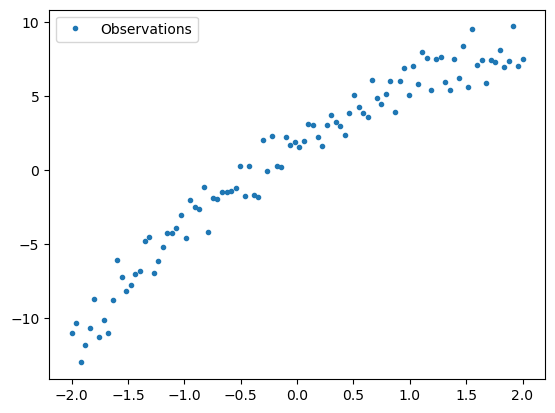

In [3]:
global y
global x
global dx

x = np.linspace(-2.0,2.0,100)
p = np.asarray([2.0,5.0,-1.0])
y = model(p,x) + np.random.randn(len(x))

indicies = np.arange(len(p))
xp = (x*np.ones((len(p),len(x)))).T
dx = np.power(xp,indicies).T

plt.plot(x,y,'.')

plt.legend(['Observations'])
plt.show()

## Initialise `HMCSampler` and assign `U` and `dU` and `qi`

`qi`: the initial guess for the parameters of interest. Walkers will be initialised close to this position in parameter space

Also set some of the optional parameters (these will use default values is not specified)

`n_samples`: the number of samples each walker will return

`n_burnin`: the number of samples that will be discarded from the start of each chain (each walker has a  separate chain). The total samples collected is n_burnin + n_samples

`lf_length`: the path length used by the leap-frog algorithm to traverse the phase-space i.e the length of the orbit segment



In [4]:
smp = HMCSampler()

smp.U = U
#smp.dU = dU

smp.dim_labels = [r"$p_0$",r"$p_1$",r"$p_2$"]
smp.qi = np.asarray([1.5,4.0,0.0])

smp.n_samples = 1000
smp.n_burnin = 1000
smp.lf_length = 0.075


## Run HMC sampling by calling `run_hmc` method

Collected samples are returned into the attribute `samples`

In [5]:
smp.run_hmc()

You can view the chains using the `plot_chains` method

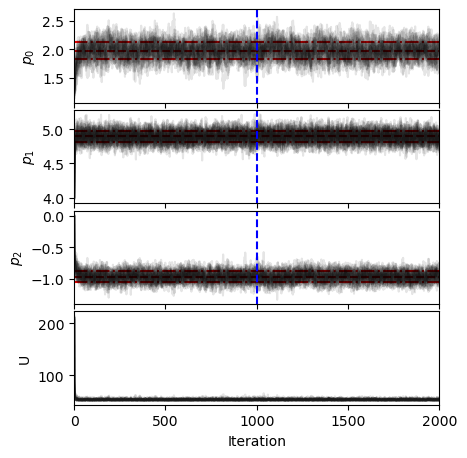

In [6]:
chains_plot = smp.plot_chains()

You can collect `n_samples` more samples by simply calling the `run_hmc` method again

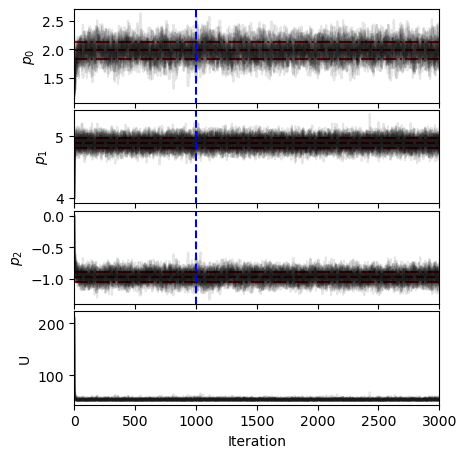

In [7]:
smp.run_hmc()
chain_plot = smp.plot_chains()

## Plot fitted model using median value of parameter samples

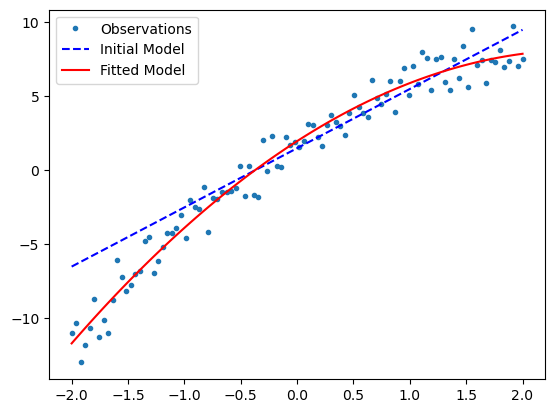

In [8]:
y0 = model(smp.qi,x)
py = model((np.median(smp.samples,axis=0)),x)

plt.plot(x,y,'.')
plt.plot(x,y0,'b--')
plt.plot(x,py,'r-')
plt.legend(['Observations','Initial Model','Fitted Model'])
plt.show()


## Plot samples of parameters of interest

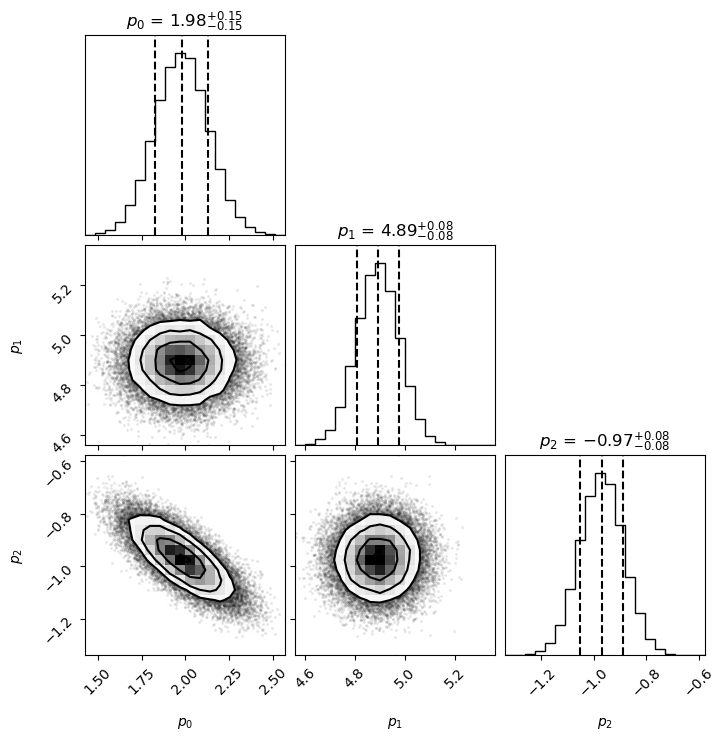

In [9]:
sample_plot = smp.plot_samples()

## Plot first 10 orbit segments of a single walker

This can be used to check that the sampler is efficiently traversing the parameter space. If the orbit segments are too-short, increase the leap-frog path length `lf_length`.

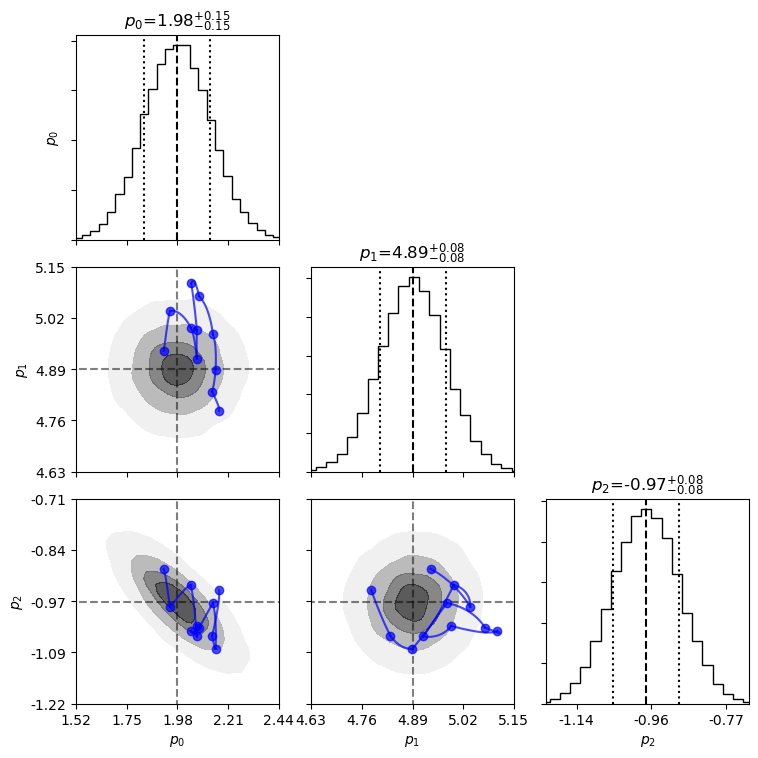

In [10]:
orbit_plot = smp.plot_orbits()

## Compare uncertainties to estimates from Fisher Information Matrix (Inverse Hessian of U)

In [11]:
#Assume median from samples is the maximum likelihood estimate
median_solution = np.median(smp.samples, axis=0) 

#Evaluate hessian at maximum likelihood estimate
hess = ddU(np.asarray([median_solution]*1).T)

#Invert hessian to get parameter covariance matrix
invHess = np.linalg.inv(hess[:,:,0])

#Get standard deviation of parameters from covariance matrix
param_uncertainty = np.sqrt(np.diag(invHess))

for i in range(3):
    print('p_'+str(i)+' = '+ '{:.2f}'.format(median_solution[i]) + ' +/- ' + '{:.2f}'.format(param_uncertainty[i]))


p_0 = 1.98 +/- 0.15
p_1 = 4.89 +/- 0.09
p_2 = -0.97 +/- 0.08


## Compare to scipy curve_fit

In [12]:
from scipy.optimize import curve_fit

def model_for_curvefit(x, *p):
    return model(p,x)

res = curve_fit(model_for_curvefit, x, y, p0=[1.5,4.0,0.0], absolute_sigma=True)

params = res[0]
cov = res[1]

for i in range(3):
    print('p_'+str(i)+' = '+ '{:.2f}'.format(params[i]) + ' +/- ' + '{:.2f}'.format(np.sqrt(cov[i,i])))

p_0 = 1.98 +/- 0.15
p_1 = 4.89 +/- 0.09
p_2 = -0.97 +/- 0.08


## Compare to scipy numerical Hessian

In [13]:
from scipy.differentiate import hessian

res = hessian(smp.U,median_solution)

hessian_sp = res.ddf

invHess_sp = np.linalg.inv(hessian_sp)

for i in range(3):
    print('p_'+str(i)+' = '+ '{:.2f}'.format(median_solution[i]) + ' +/- ' + '{:.2f}'.format(np.sqrt(invHess_sp[i,i])))

p_0 = 1.98 +/- 0.15
p_1 = 4.89 +/- 0.09
p_2 = -0.97 +/- 0.08


## Comparison witn `emcee`

In [14]:
import emcee
import corner

#note that emcee requires the log likelihood function, not the potential (which is the negative of the log likelihood)
sampler = emcee.EnsembleSampler(smp.n_walkers, len(smp.qi), lambda q: -1.0*smp.U(q))


In [15]:
q_init = np.asarray([smp.qi]*smp.n_walkers) + 0.1*np.random.randn(smp.n_walkers,3)

#burn in
burnin = sampler.run_mcmc(q_init, smp.n_burnin)
sampler.reset()


#collect samples
fs = sampler.run_mcmc(burnin, smp.n_samples)


In [16]:
emcee_pctl = np.percentile(sampler.flatchain, [16, 50, 84], axis=0)
hmc_pctl = np.percentile(smp.samples, [16, 50, 84], axis=0)

print('True values')
for i in range(3):
    print('p_'+str(i)+' = '+ '{:.2f}'.format(p[i]))

print('emcee')
for i in range(3):
    print('p_'+str(i)+' = '+ '{:.2f}'.format(emcee_pctl[1,i]) + ' +/- ' + '{:.2f}'.format(emcee_pctl[2,i]-emcee_pctl[1,i]))
    
print('HMC')
for i in range(3):
    print('p_'+str(i)+' = '+ '{:.2f}'.format(hmc_pctl[1,i]) + ' +/- ' + '{:.2f}'.format(hmc_pctl[2,i]-hmc_pctl[1,i]))

print('curve_fit')
for i in range(3):
    print('p_'+str(i)+' = '+ '{:.2f}'.format(params[i]) + ' +/- ' + '{:.2f}'.format(np.sqrt(cov[i,i])))


True values
p_0 = 2.00
p_1 = 5.00
p_2 = -1.00
emcee
p_0 = 1.98 +/- 0.15
p_1 = 4.89 +/- 0.09
p_2 = -0.97 +/- 0.08
HMC
p_0 = 1.98 +/- 0.15
p_1 = 4.89 +/- 0.08
p_2 = -0.97 +/- 0.08
curve_fit
p_0 = 1.98 +/- 0.15
p_1 = 4.89 +/- 0.09
p_2 = -0.97 +/- 0.08


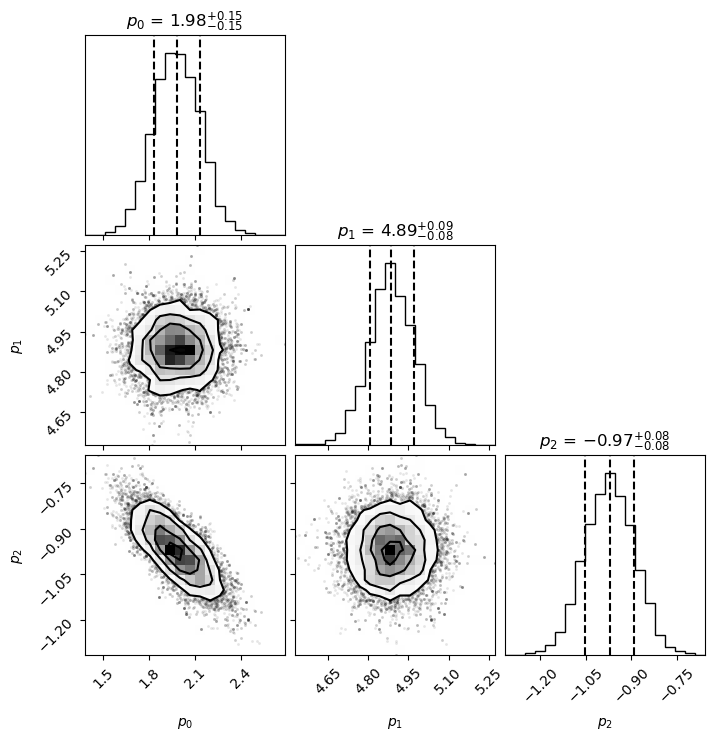

In [17]:
emcee_smp = HMCSampler()
emcee_smp.dim_labels = [r"$p_0$",r"$p_1$",r"$p_2$"]
emcee_smp.samples = sampler.flatchain

emcee_fig = emcee_smp.plot_samples()

In [18]:
smp.save('example',add_time=False)


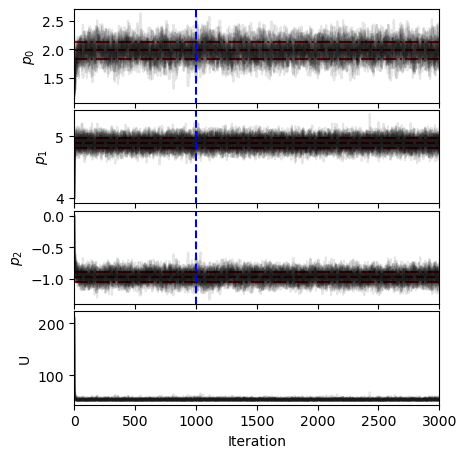

In [19]:

loaded_smp = HMCSampler()

loaded_smp.load('example.hmc')

loaded_smp.U = U
loaded_smp.dU = dU

chains_plt = loaded_smp.plot_chains()

In [20]:
loaded_smp.save_every = 500
loaded_smp.file_name = 'example'
loaded_smp.run_hmc()

example.hmc


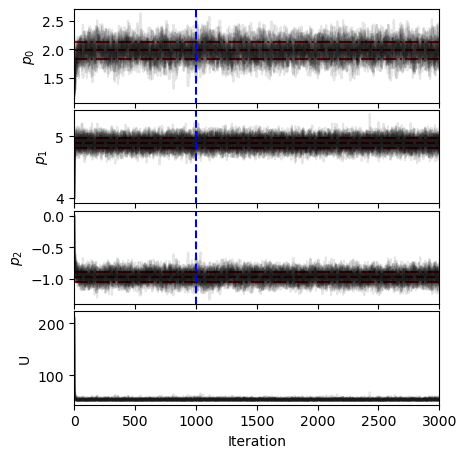

example_2025-03-27-20-46-07.hmc


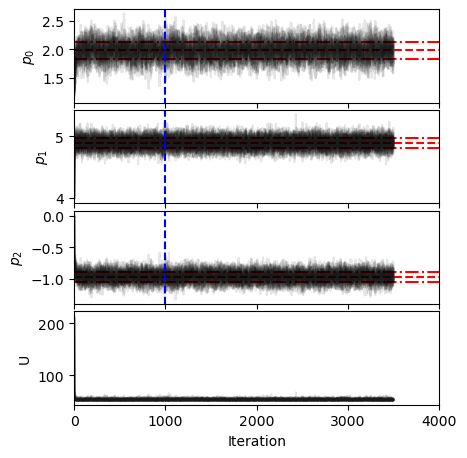

example_2025-03-27-20-46-11.hmc


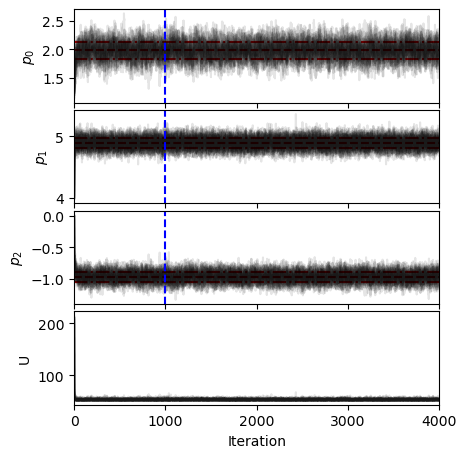

In [21]:
import glob
import os

patern = 'example*.hmc'

file_list = glob.glob(patern)
file_list.sort()

for file in file_list:
    print(file)
    loaded_smp.load(file)
    loaded_smp.U = U
    loaded_smp.dU = dU
    loaded_smp.plot_chains()
    plt.show()
    os.remove(file)

    

## Compare different path lengths

#### `lf_length` = 0.005

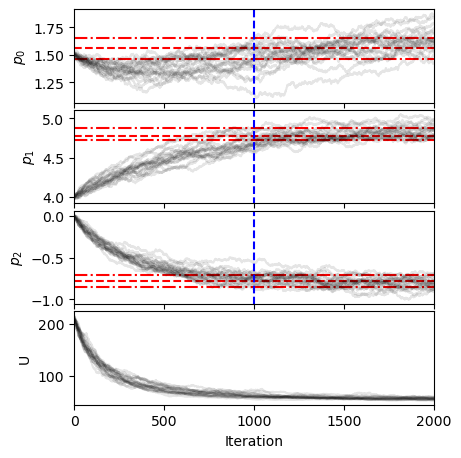

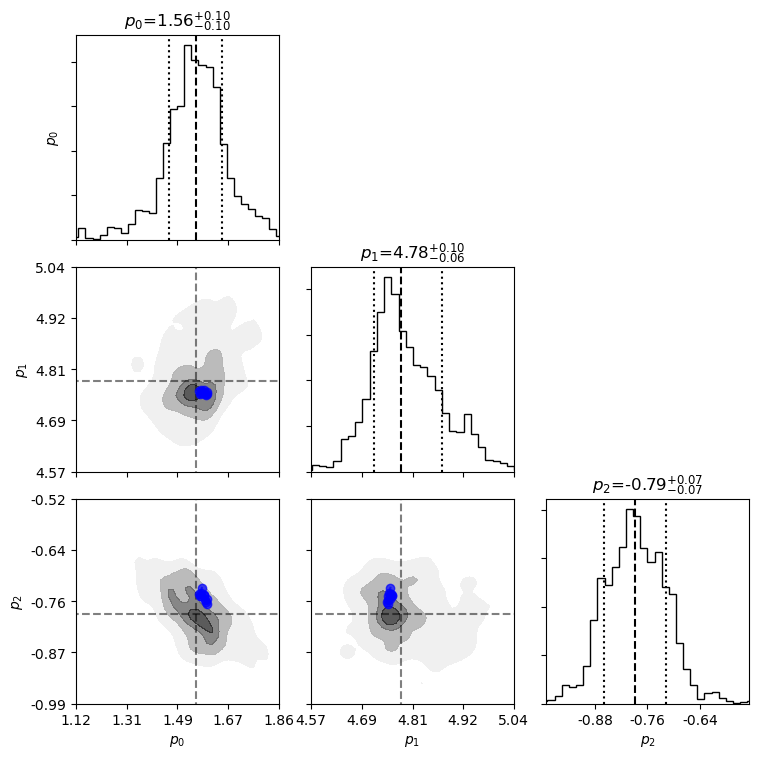

In [22]:
smp.reset()
smp.lf_length = 0.005 #too short, probably needs a longer burn in if this is going to work
smp.run_hmc()
chains_plot = smp.plot_chains()
orbit_plot = smp.plot_orbits()

#### `lf_length` = 0.05

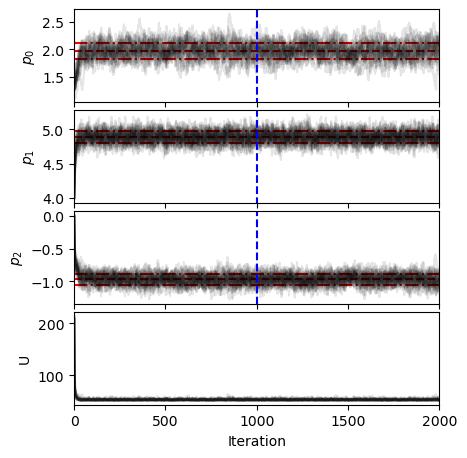

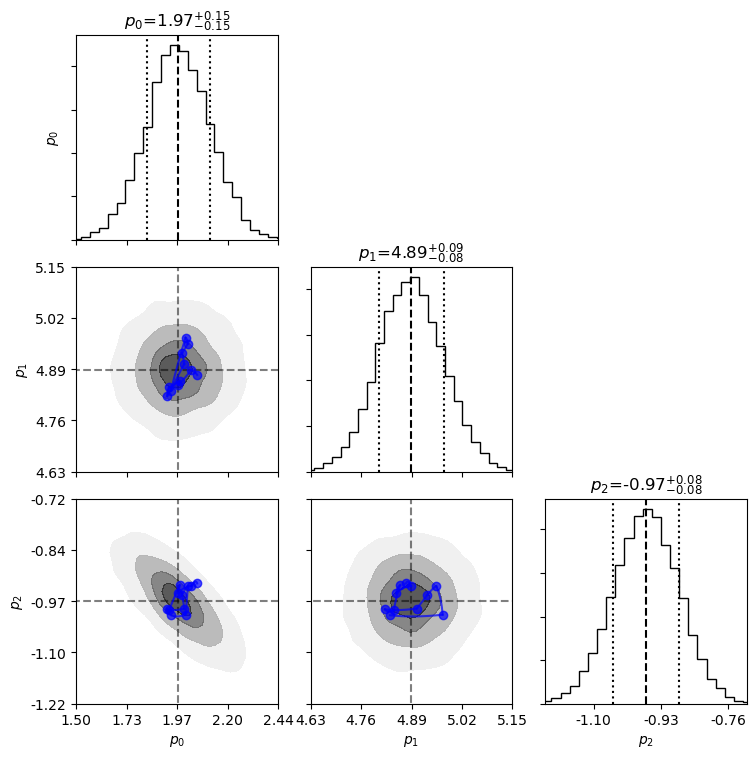

In [23]:
smp.reset()
smp.lf_length = 0.05 #about right, could be a bit longer
smp.run_hmc()
chains_plot = smp.plot_chains()
orbit_plot = smp.plot_orbits()

#### `lf_length` = 0.5

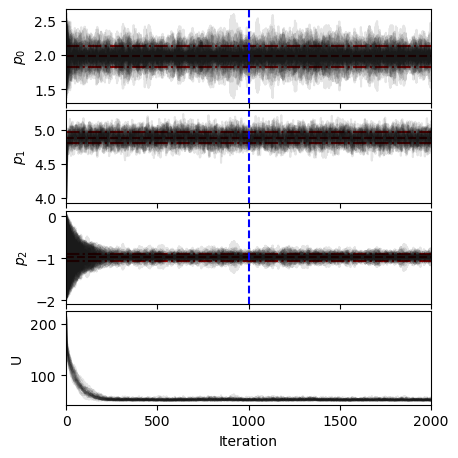

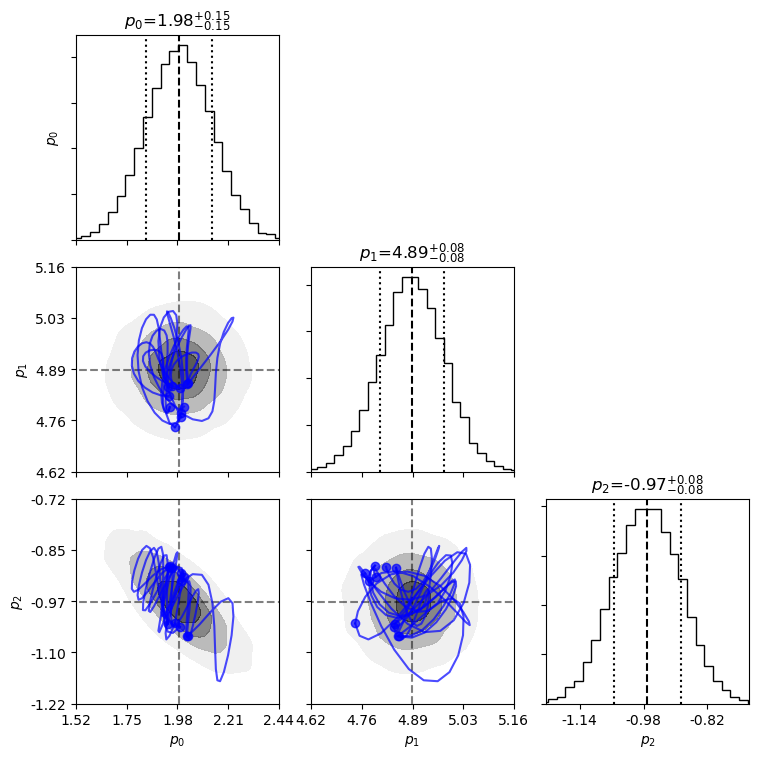

In [24]:
smp.reset()
smp.lf_length = 0.5 #probably a bit long, but looks like it worked ok - note that it doesn't significantly change the sampled distributions
smp.run_hmc()
chains_plot = smp.plot_chains()
orbit_plot = smp.plot_orbits()